# Описание


![Image of Yaktocat](https://www.machinelearningmastery.ru/img/0-572396-439226.png)

* **key** - строка, идентифицирующая каждую строку как в train, так и test. 
Содержит время (pickup_date) и уникальное целое число.
key следует использовать в качестве поля уникального идентификатора. 
Необходимо в финальном CSV-файле для отправки. 
Может быть полезно для cross-validation в train.


*Features*
* **pickup_datetime** - время, когда началась поездка на такси.
* **pickup_longitude** - float, координаты **долготы** начала поездки.
* **pickup_latitude** - float, координаты **широты** начала поездки.
* **dropoff_longitude** - float, координаты **долготы** конца поездки.
* **dropoff_latitude** - float, координаты **широты** конца поездки.
* **passenger_count** - целое число, указывающее количество пассажиров в такси.


*Target*
* **fare_amount** - float, сумма в долларах стоимости поездки на такси. Это значение есть только в обучающем наборе.
Это то, что необходимо предсказать в файле test (+ требуется в финальном CSV-файле к отправке).

Задача линейной регресси.

* Пропущенные значения
* Масштабирование
* Кодирование невещественных признаков

# 1) Удаление пропусков, фильтр

Устанавливаем нужные библиотеки

In [ ]:
pip install holidays

In [ ]:
pip install catboost

In [ ]:
#Импортируем нужные библиотеки
from google.colab import drive
from holidays import UnitedStates as hol

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import ssl
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


In [ ]:
#Подключаемся к источнику информации
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Выгружаем каждую 25 строку из файла с тренировочными данными
data_train_full=pd.read_csv('/content/drive/MyDrive/train.csv',skiprows=lambda x: (x != 0) and x % 25)
shape_begin=data_train_full.shape
shape_begin

(2216954, 8)

In [ ]:
data_train_full.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-12-10 15:37:00.00000020,6.1,2009-12-10 15:37:00 UTC,-73.969622,40.756973,-73.981152,40.759712,1
1,2013-01-29 12:26:00.000000154,9.0,2013-01-29 12:26:00 UTC,-73.992253,40.742657,-73.983597,40.755947,1
2,2014-12-08 16:00:01.0000001,16.5,2014-12-08 16:00:01 UTC,-73.982800,40.745287,-74.014250,40.702935,1
3,2011-06-09 00:53:00.00000066,5.7,2011-06-09 00:53:00 UTC,-73.983052,40.722588,-73.988022,40.733738,3
4,2013-01-17 17:22:00.00000043,8.0,2013-01-17 17:22:00 UTC,0.000000,0.000000,0.000000,0.000000,2


In [ ]:
#Сразу выгрузим тестовые данные
data_test_full=pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
#размер датасета
data_train_full.shape

(2216954, 8)

In [ ]:
#типы признаков:
data_train_full.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [ ]:
#Описательная статистика тренировочных данных
#Видим, что есть отрицательные значения в цене и координатах. 
#Так же есть какое-то странное большое число пассажиров
#Нужно обработать эти данные
data_train_full.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.216954e+06,2.216954e+06,2.216954e+06,2.216932e+06,2.216932e+06,2.216954e+06
mean,1.134439e+01,-7.250070e+01,3.991505e+01,-7.250946e+01,3.992008e+01,1.685357e+00
std,1.000918e+01,1.365404e+01,1.055121e+01,1.355961e+01,9.856440e+00,1.323337e+00
min,-6.000000e+01,-3.337128e+03,-3.492264e+03,-3.394483e+03,-2.877122e+03,0.000000e+00
25%,6.000000e+00,-7.399204e+01,4.073494e+01,-7.399140e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398179e+01,4.075264e+01,-7.398015e+01,4.075318e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,3.130300e+03,3.457626e+03,3.280144e+03,3.456223e+03,3.313673e+03,2.080000e+02


In [ ]:
# Посмотрим, есть ли пропуски:
data_train_full.isna().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    22
dropoff_latitude     22
passenger_count       0
dtype: int64

In [ ]:
# удаляем стрки, в которых есть пропуски
data_train_full.dropna(inplace=True) 
data_train_full.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

## Выбросы.

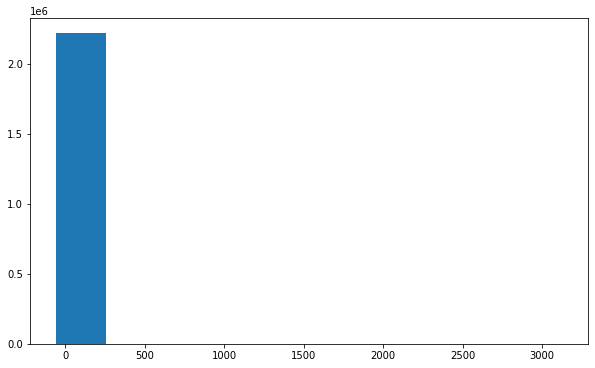

In [ ]:
#Построим гистограмму целевой переменной
plt.figure(figsize=(10,6))
plt.hist(data_train_full['fare_amount']);

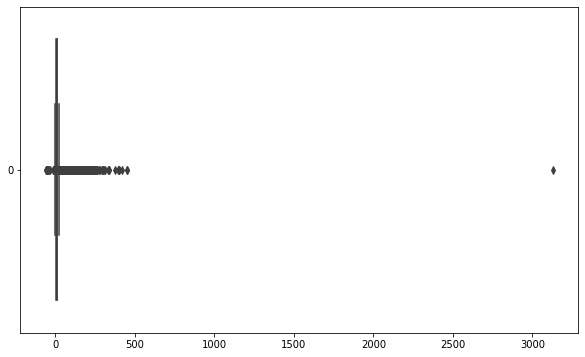

In [ ]:
#Построим ящик с усами целевой переменной
plt.figure(figsize=(10,6))
sns.boxplot(data=data_train_full['fare_amount'], orient = 'h');
#Видим, что есть выбросы

In [ ]:
# Количество поездок, которые превышают стоимость 300 $ - 14 шт.
# Количество поездок, которые стоили менее 1$ - 168 шт.
# Их можно отбросить, что бы избавиться от сильных выбросов, 
#   странно дешевых поездок и поездок с отрицательной стоимостью
# Так же уберем поездки, в которых было более 6 пассажиров и не было пассажиров
d1 = data_train_full.shape

data_train = data_train_full[(data_train_full['fare_amount'] <= 300) & 
                (data_train_full['fare_amount'] >= 1) &
                (data_train_full['passenger_count'] >= 1) & 
                (data_train_full['passenger_count'] <= 6)]

d2 = data_train.shape

print(f'Удалили {d1[0]-d2[0]} событий.')
print(f'Это {round((d1[0]-d2[0])/shape_begin[0]*100,2)}% от общей выборки.')

Удалили 8102 событий.
Это 0.37% от общей выборки.


In [ ]:
data_train.shape

(2208830, 8)

In [ ]:
# фильтруем строки по координатам
# найдем рамки тестового датасета
extr_coord=(min(data_test_full.pickup_longitude.min(), 
          data_test_full.dropoff_longitude.min()), 
      max(data_test_full.pickup_longitude.max(), 
          data_test_full.dropoff_longitude.max()),
      min(data_test_full.pickup_latitude.min(), 
          data_test_full.dropoff_latitude.min()), 
      max(data_test_full.pickup_latitude.max(), 
          data_test_full.dropoff_latitude.max()))
extr_coord


(-74.263242, -72.986532, 40.568973, 41.709555)

In [ ]:
# Установим такие же границы на обучающую выборку + небольшой запас
boundaries = [-74.5,-72.8,40.5,41.8]

In [ ]:
d1 = data_train.shape
data_train=data_train[(data_train.pickup_longitude <= boundaries[1]) & 
                      (data_train.pickup_longitude >= boundaries[0]) &
                      (data_train.dropoff_longitude <= boundaries[1]) & 
                      (data_train.dropoff_longitude >= boundaries[0]) &
                      (data_train.pickup_latitude <= boundaries[3]) & 
                      (data_train.pickup_latitude >= boundaries[2]) &
                      (data_train.dropoff_latitude <= boundaries[3]) & 
                      (data_train.dropoff_latitude >= boundaries[2])]  
d2 = data_train.shape          
print(f'Удалили {d1[0]-d2[0]} событий.')
print(f'Это {round((d1[0]-d2[0])/shape_begin[0]*100,2)}% от общей выборки.')


Удалили 46792 событий.
Это 2.11% от общей выборки.


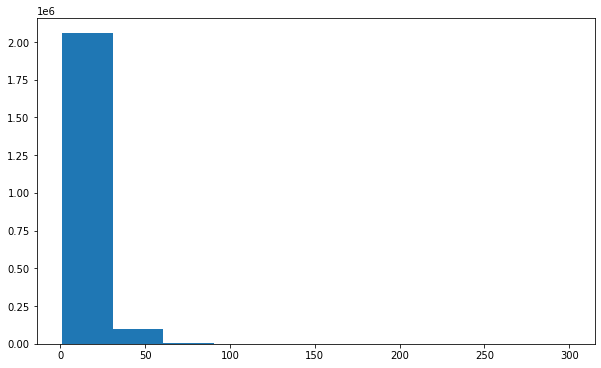

In [ ]:
#Построим гистограмму целевой переменной после фильтра
plt.figure(figsize=(10,6))
plt.hist(data_train['fare_amount']);

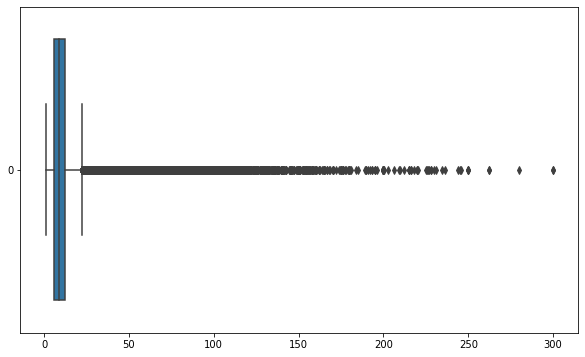

In [ ]:
#Построим ящик с усами целевой переменной после фильтра
plt.figure(figsize=(10,6))
sns.boxplot(data=data_train['fare_amount'], orient = 'h');

## Фильтр

In [ ]:
# удалим точки в прилежащих акваториях
# https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration
# загрузим картинку карту нью-йорка

ssl._create_default_https_context = ssl._create_unverified_context
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

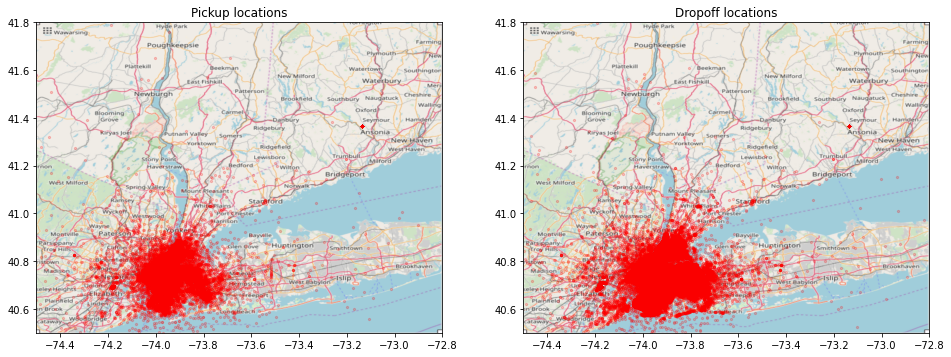

In [ ]:
# визуализируем расположение точек посадки и высадки в обучающей выборке

fig, axs = plt.subplots(1, 2, figsize=(16,10))
axs[0].scatter(data_train.pickup_longitude, data_train.pickup_latitude, zorder=1, alpha=0.2, c='r', s=5)
axs[0].set_xlim((boundaries[0], boundaries[1]))
axs[0].set_ylim((boundaries[2], boundaries[3]))
axs[0].set_title('Pickup locations')
axs[0].imshow(nyc_map, zorder=0, extent=boundaries)

axs[1].scatter(data_train.dropoff_longitude, data_train.dropoff_latitude, zorder=1, alpha=0.2, c='r', s=5)
axs[1].set_xlim((boundaries[0], boundaries[1]))
axs[1].set_ylim((boundaries[2], boundaries[3]))
axs[1].set_title('Dropoff locations')
axs[1].imshow(nyc_map, zorder=0, extent=boundaries)

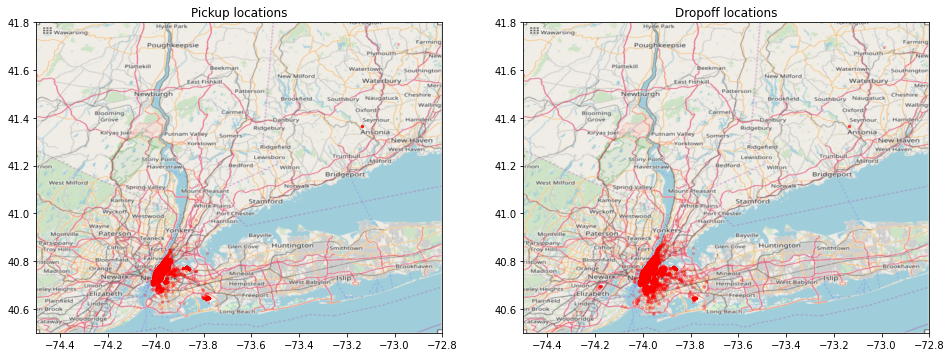

In [ ]:
# визуализируем расположение точек посадки и высадки в тестовой выборке
# в тестовой выборке данные заметно чище

fig, axs = plt.subplots(1, 2, figsize=(16,10))
axs[0].scatter(data_test_full.pickup_longitude, data_test_full.pickup_latitude, zorder=1, alpha=0.2, c='r', s=5)
axs[0].set_xlim((boundaries[0], boundaries[1]))
axs[0].set_ylim((boundaries[2], boundaries[3]))
axs[0].set_title('Pickup locations')
axs[0].imshow(nyc_map, zorder=0, extent=boundaries)

axs[1].scatter(data_test_full.dropoff_longitude, data_test_full.dropoff_latitude, zorder=1, alpha=0.2, c='r', s=5)
axs[1].set_xlim((boundaries[0], boundaries[1]))
axs[1].set_ylim((boundaries[2], boundaries[3]))
axs[1].set_title('Dropoff locations')
axs[1].imshow(nyc_map, zorder=0, extent=boundaries)

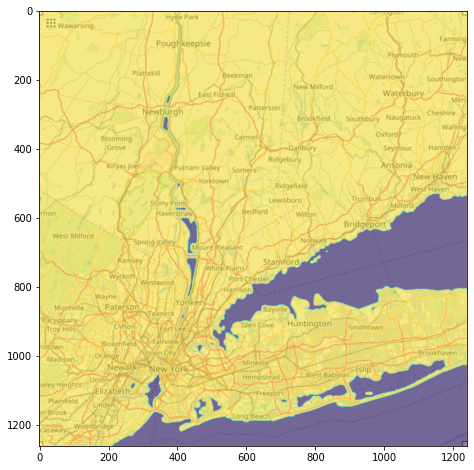

In [ ]:
# добавляем маску (черно-белая картинка, 1-суша, 0 - вода) 

#считываем маску в массив (RGBA картинка) и переводим в boolean
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9 #переводим в true и false

plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0) #первый слой наша карта
plt.imshow(nyc_mask, zorder=1, alpha=0.5) #второй слой наша маска

In [ ]:
nyc_mask.shape

(1262, 1242)

In [ ]:
d1 = data_train.shape

# переводим долготу, широту в координаты xy картинки nyc_map по формуле
# нужно составить пропорцию по оси x и y
# например, ширина_маски*(долгота-долгта_мин)/(долгота_макс-долгота_мин),высота_маски-высота_маски*(широта-широта_мин)/(широта_макс-широта_мин)

pickup_x, pickup_y = (nyc_mask.shape[1]*
                     (data_train.pickup_longitude - boundaries[0])/
                     (boundaries[1]-boundaries[0])).astype('int'), \
                     (nyc_mask.shape[0] - nyc_mask.shape[0]*
                     (data_train.pickup_latitude - boundaries[2])/
                     (boundaries[3]-boundaries[2])).astype('int')

dropoff_x, dropoff_y = (nyc_mask.shape[1]*
                       (data_train.dropoff_longitude - boundaries[0])/
                       (boundaries[1]-boundaries[0])).astype('int'), \
                       (nyc_mask.shape[0] - nyc_mask.shape[0]*
                       (data_train.dropoff_latitude - boundaries[2])/
                       (boundaries[3]-boundaries[2])).astype('int')

# накладываем маску на наши координаты точек, в idx сохраняем массив 
#[true-вода, false-суша] для каждой точки
idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]

# сохраняем в обучающий датасет только точки со значением суша 
#(накладываем на датасет фильтр idx)
data_train = data_train[idx]
d2 = data_train.shape

print(f'Удалили {d1[0]-d2[0]} событий.')
print(f'Это {round((d1[0]-d2[0])/shape_begin[0]*100,2)}% от общей выборки.')

Удалили 452 событий.
Это 0.02% от общей выборки.


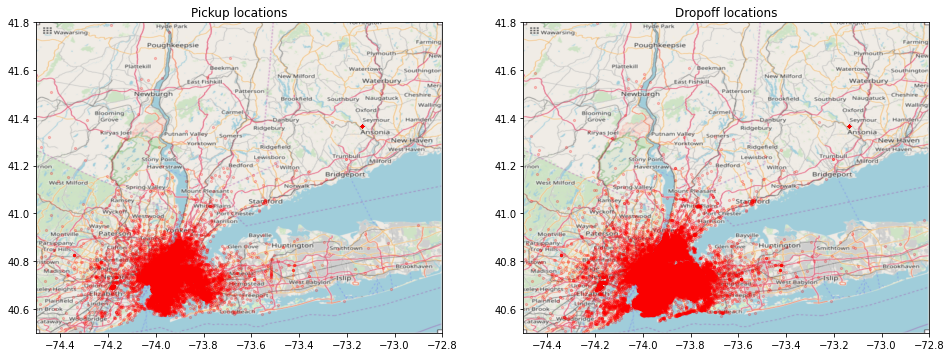

In [ ]:
# визуализируем расположение точек посадки и высадки в обучающей выборке (после удаления точек в воде) 

fig, axs = plt.subplots(1, 2, figsize=(16,10))
axs[0].scatter(data_train.pickup_longitude, data_train.pickup_latitude, zorder=1, alpha=0.2, c='r', s=5)
axs[0].set_xlim((boundaries[0], boundaries[1]))
axs[0].set_ylim((boundaries[2], boundaries[3]))
axs[0].set_title('Pickup locations')
axs[0].imshow(nyc_map, zorder=0, extent=boundaries)

axs[1].scatter(data_train.dropoff_longitude, data_train.dropoff_latitude, zorder=1, alpha=0.2, c='r', s=5)
axs[1].set_xlim((boundaries[0], boundaries[1]))
axs[1].set_ylim((boundaries[2], boundaries[3]))
axs[1].set_title('Dropoff locations')
axs[1].imshow(nyc_map, zorder=0, extent=boundaries)

# 2) Добавление новых признаков

## Добавляем столбец "Время посадки", "Месяц" и "Год"

In [ ]:
# в столбце 'pickup_datetime' час лежит в диапазоне строки от '11' до '13' символа (2009-06-15 17:26:21 UTC) 
data_train['pick up time'] = data_train['pickup_datetime'].str[11:13] 
data_train['month'] = data_train['pickup_datetime'].str[5:7] # "месяц" - с 5 до 7 символа
data_train['year'] = data_train['pickup_datetime'].str[:4] # "год" - с 0 до 4 символа
    
data_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pick up time,month,year
0,2009-12-10 15:37:00.00000020,6.1,2009-12-10 15:37:00 UTC,-73.969622,40.756973,-73.981152,40.759712,1,15,12,2009
1,2013-01-29 12:26:00.000000154,9.0,2013-01-29 12:26:00 UTC,-73.992253,40.742657,-73.983597,40.755947,1,12,01,2013
2,2014-12-08 16:00:01.0000001,16.5,2014-12-08 16:00:01 UTC,-73.982800,40.745287,-74.014250,40.702935,1,16,12,2014
3,2011-06-09 00:53:00.00000066,5.7,2011-06-09 00:53:00 UTC,-73.983052,40.722588,-73.988022,40.733738,3,00,06,2011
5,2015-04-19 22:21:12.0000005,8.0,2015-04-19 22:21:12 UTC,-73.985489,40.747280,-74.007675,40.740768,1,22,04,2015


## Добавляем столбец "Праздники"

In [ ]:
 # этот столбец отображает дату, месяц, год
data_train['date'] = data_train['pickup_datetime'].str[:10]
data_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pick up time,month,year,date
0,2009-12-10 15:37:00.00000020,6.1,2009-12-10 15:37:00 UTC,-73.969622,40.756973,-73.981152,40.759712,1,15,12,2009,2009-12-10
1,2013-01-29 12:26:00.000000154,9.0,2013-01-29 12:26:00 UTC,-73.992253,40.742657,-73.983597,40.755947,1,12,01,2013,2013-01-29
2,2014-12-08 16:00:01.0000001,16.5,2014-12-08 16:00:01 UTC,-73.982800,40.745287,-74.014250,40.702935,1,16,12,2014,2014-12-08
3,2011-06-09 00:53:00.00000066,5.7,2011-06-09 00:53:00 UTC,-73.983052,40.722588,-73.988022,40.733738,3,00,06,2011,2011-06-09
5,2015-04-19 22:21:12.0000005,8.0,2015-04-19 22:21:12 UTC,-73.985489,40.747280,-74.007675,40.740768,1,22,04,2015,2015-04-19


In [ ]:
#Работаем с праздничными данными. Найдем дни перед праздниками и предпраздничные субботы
holidays = hol() # это выходные дни в USA

#очень странный блок. Но если его не прописать, праздники не выгружаются
holidays.get('2009-01-01')
holidays.get('2010-01-01')
holidays.get('2011-01-01')
holidays.get('2012-01-01')
holidays.get('2013-01-01')
holidays.get('2014-01-01')
holidays.get('2015-01-01')
##########################################

#Создадим датафрэйм с нужными нам данными
holidays = [i for i in holidays.keys()]
holidays=pd.DataFrame(holidays, columns=['Date'])
holidays['Date']=pd.to_datetime(holidays['Date'])#Даты праздников
holidays['Pre_Date']=holidays['Date']+dt.timedelta(days=-1)#День перед праздником
holidays['Weekday']=holidays['Date'].dt.day_name()#День недели
holidays['W']=holidays['Date'].dt.weekday#номер дня недели
holidays['Pre_Saturday']=np.where(holidays['W']==6,
                  holidays['Date']+pd.to_timedelta(-1, unit='D'),#Предпраздничный день
                  holidays['Date']+pd.to_timedelta(-holidays['W']-2, unit='D')) #Предпраздничная суббота
holidays['W_saturday']=holidays['Pre_Saturday'].dt.day_name()#для проверки
holidays.head()

,Date,Pre_Date,Weekday,W,Pre_Saturday,W_saturday
0,2009-01-01,2008-12-31,Thursday,3,2008-12-27,Saturday
1,2009-01-19,2009-01-18,Monday,0,2009-01-17,Saturday
2,2009-02-16,2009-02-15,Monday,0,2009-02-14,Saturday
3,2009-05-25,2009-05-24,Monday,0,2009-05-23,Saturday
4,2009-07-04,2009-07-03,Saturday,5,2009-06-27,Saturday


In [ ]:
# конвертируем столбец в формат даты
data_train['date'] = pd.to_datetime(data_train['date']) 
#Бинарный столбец праздник или нет
data_train['Holiday']=data_train['date'].isin(holidays['Date'])*1
#Бинарный столбец предпраздничный день или предпраздничная суббота
data_train['Pre_Holiday_day/saturday']=((
        (data_train['date'].isin(holidays['Pre_Date'])) & 
        (data_train['date'].isin(holidays['Date'])==False)) | 
        (data_train['date'].isin(holidays['Pre_Saturday'])))*1
                         
data_train.head(10)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pick up time,month,year,date,Holiday,Pre_Holiday_day/saturday
0,2009-12-10 15:37:00.00000020,6.1,2009-12-10 15:37:00 UTC,-73.969622,40.756973,-73.981152,40.759712,1,15,12,2009,2009-12-10,0,0
1,2013-01-29 12:26:00.000000154,9.0,2013-01-29 12:26:00 UTC,-73.992253,40.742657,-73.983597,40.755947,1,12,01,2013,2013-01-29,0,0
2,2014-12-08 16:00:01.0000001,16.5,2014-12-08 16:00:01 UTC,-73.982800,40.745287,-74.014250,40.702935,1,16,12,2014,2014-12-08,0,0
3,2011-06-09 00:53:00.00000066,5.7,2011-06-09 00:53:00 UTC,-73.983052,40.722588,-73.988022,40.733738,3,00,06,2011,2011-06-09,0,0
5,2015-04-19 22:21:12.0000005,8.0,2015-04-19 22:21:12 UTC,-73.985489,40.747280,-74.007675,40.740768,1,22,04,2015,2015-04-19,0,0
6,2015-02-27 07:50:56.0000003,10.5,2015-02-27 07:50:56 UTC,-73.944023,40.775959,-73.955048,40.785080,1,07,02,2015,2015-02-27,0,0
7,2013-01-05 21:36:00.000000198,5.5,2013-01-05 21:36:00 UTC,-73.989692,40.735497,-73.982012,40.739392,1,21,01,2013,2013-01-05,0,0
8,2014-07-21 14:03:00.00000087,12.0,2014-07-21 14:03:00 UTC,-73.973857,40.764185,-73.994435,40.750242,3,14,07,2014,2014-07-21,0,0
9,2009-04-21 22:59:27.0000003,7.3,2009-04-21 22:59:27 UTC,-73.968534,40.752603,-73.992625,40.742916,1,22,04,2009,2009-04-21,0,0
10,2010-01-17 22:07:00.00000098,5.7,2010-01-17 22:07:00 UTC,-73.967598,40.756242,-73.953277,40.768330,1,22,01,2010,2010-01-17,0,1


In [ ]:
#Посмотрим сбалансированность созданных столбцов
data_train['Holiday'].value_counts()

0    2112575
1      49011
Name: Holiday, dtype: int64

In [ ]:
data_train['Pre_Holiday_day/saturday'].value_counts()


0    2052290
1     109296
Name: Pre_Holiday_day/saturday, dtype: int64

## Добавляем столбец "День недели"

In [ ]:
# Находим день недели из колонки "pickup_datetime"
data_train['Weekday']=data_train.date.dt.day_name()
data_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pick up time,month,year,date,Holiday,Pre_Holiday_day/saturday,Weekday
0,2009-12-10 15:37:00.00000020,6.1,2009-12-10 15:37:00 UTC,-73.969622,40.756973,-73.981152,40.759712,1,15,12,2009,2009-12-10,0,0,Thursday
1,2013-01-29 12:26:00.000000154,9.0,2013-01-29 12:26:00 UTC,-73.992253,40.742657,-73.983597,40.755947,1,12,01,2013,2013-01-29,0,0,Tuesday
2,2014-12-08 16:00:01.0000001,16.5,2014-12-08 16:00:01 UTC,-73.982800,40.745287,-74.014250,40.702935,1,16,12,2014,2014-12-08,0,0,Monday
3,2011-06-09 00:53:00.00000066,5.7,2011-06-09 00:53:00 UTC,-73.983052,40.722588,-73.988022,40.733738,3,00,06,2011,2011-06-09,0,0,Thursday
5,2015-04-19 22:21:12.0000005,8.0,2015-04-19 22:21:12 UTC,-73.985489,40.747280,-74.007675,40.740768,1,22,04,2015,2015-04-19,0,0,Sunday


## Добавляем столбец "Расстояние". Используем Manhattan.

manhattan_distances

https://www.kaggle.com/ojones3/feature-engineering-corrected-manhattan-distance

Остров Манхэттен разбит на квадраты, которые наклонены примерно на 29 градусов по часовой стрелке от севера. 

In [ ]:
# Вычисяем разницу координат:

# координаты посадки:
a1 = data_train['pickup_latitude']
b1 = data_train['pickup_longitude']
    
# координаты высадки
a2 = data_train['dropoff_latitude']
b2 = data_train['dropoff_longitude']

vector_degr = abs(a1 - a2) + abs(b1 - b2)

# Переводим вектор в расстояние (miles)

# 1 градус широты равен 69 милям - latitude
# Долгота в милях варьируется в зависимости от того, в какой точке мира мы находимся.
# В NY 1 градус долготы равен примерно 50 милям - longitude

lat = abs(a1 - a2)*69
lon = abs(b1 - b2)*50
vector_miles = lat + lon

In [ ]:
### Корректируем расчет расстояния с учетом наклона улиц Манхэттена на 29 градусов от севера по ч. стрелке
meas_ang = 0.506 # 29 град. = 0.506 радиан

def Manhattan (data, lat, lon):
  Euclidean = (lat**2 + lon**2)**0.5   
  manh_long = (Euclidean * np.sin(np.arctan(lon / lat) - meas_ang)).abs()
  manh_lat = (Euclidean * np.cos(np.arctan(lon / lat) - meas_ang)).abs()
  data['Manhattan_dist'] = manh_long + manh_lat

Manhattan (data_train, lat, lon)

data_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pick up time,month,year,date,Holiday,Pre_Holiday_day/saturday,Weekday,Manhattan_dist
0,2009-12-10 15:37:00.00000020,6.1,2009-12-10 15:37:00 UTC,-73.969622,40.756973,-73.981152,40.759712,1,15,12,2009,2009-12-10,0,0,Thursday,0.857386
1,2013-01-29 12:26:00.000000154,9.0,2013-01-29 12:26:00 UTC,-73.992253,40.742657,-73.983597,40.755947,1,12,01,2013,2013-01-29,0,0,Tuesday,1.077763
2,2014-12-08 16:00:01.0000001,16.5,2014-12-08 16:00:01 UTC,-73.982800,40.745287,-74.014250,40.702935,1,16,12,2014,2014-12-08,0,0,Monday,3.359191
3,2011-06-09 00:53:00.00000066,5.7,2011-06-09 00:53:00 UTC,-73.983052,40.722588,-73.988022,40.733738,3,00,06,2011,2011-06-09,0,0,Thursday,0.948916
5,2015-04-19 22:21:12.0000005,8.0,2015-04-19 22:21:12 UTC,-73.985489,40.747280,-74.007675,40.740768,1,22,04,2015,2015-04-19,0,0,Sunday,1.683204


In [ ]:
# После вычисления расстояния проверяем, появились ли пропущенные значения
data_train.isna().sum()

key                             0
fare_amount                     0
pickup_datetime                 0
pickup_longitude                0
pickup_latitude                 0
dropoff_longitude               0
dropoff_latitude                0
passenger_count                 0
pick up time                    0
month                           0
year                            0
date                            0
Holiday                         0
Pre_Holiday_day/saturday        0
Weekday                         0
Manhattan_dist              22859
dtype: int64

In [ ]:
#Есть поедки, у которых начало и конец в одной точке.
#Мы не знаем природу этих поездок, поэтому удалим их
d1 = data_train.shape

data_train.dropna(subset=['Manhattan_dist'],inplace=True)

d2 = data_train.shape

print(f'Удалили {d1[0]-d2[0]} событий.')
print(f'Это {round((d1[0]-d2[0])/data_train_full.shape[0]*100,2)}% от общей выборки.')

Удалили 22859 событий.
Это 1.03% от общей выборки.


## Добавляем столбцы с Аэропортами

In [ ]:
# добавляем признак аэропорт имени Джона Кеннеди, Нью-Йорк, США
data_train.loc[((data_train['pickup_latitude'].between(40.60, 40.67)) & 
                (data_train['pickup_longitude'].between(-73.83, -73.74))) |
               ((data_train['dropoff_latitude'].between(40.60, 40.67)) & 
                (data_train['dropoff_longitude'].between(-73.83, -73.74))), 
               'airport_JK'] = 1

# добавляем признак аэропорт Ла-Гвардия (LGA), Куинс, Нью-Йорк, США
data_train.loc[((data_train['pickup_latitude'].between(40.76, 40.782)) & 
                (data_train['pickup_longitude'].between(-73.891, -73.855))) |
               ((data_train['dropoff_latitude'].between(40.76, 40.782)) & 
                (data_train['dropoff_longitude'].between(-73.891, -73.855))), 
               'airport_LG'] = 1

# добавляем признак аэропорт Newark Liberty International Airport (EWR), Newark, NJ
data_train.loc[((data_train['pickup_latitude'].between(40.66, 40.72)) & 
                (data_train['pickup_longitude'].between(-74.180,-73.170))) |
               ((data_train['dropoff_latitude'].between(40.66, 40.72)) & 
               (data_train['dropoff_longitude'].between(-74.180,-73.170))), 
               'airport_N'] = 1

In [ ]:
#Заменим все Nan в столбцах аэропортах на 0
data_train.fillna({'airport_JK':0, 'airport_LG':0, 'airport_N':0}, inplace=True)

In [ ]:
#Переведем бинарные столбцы с аэропортами в числовые признаки
data_train[['airport_JK','airport_LG','airport_N' ]]= \
data_train[['airport_JK','airport_LG','airport_N' ]].astype(int)

## Графики "Часы"

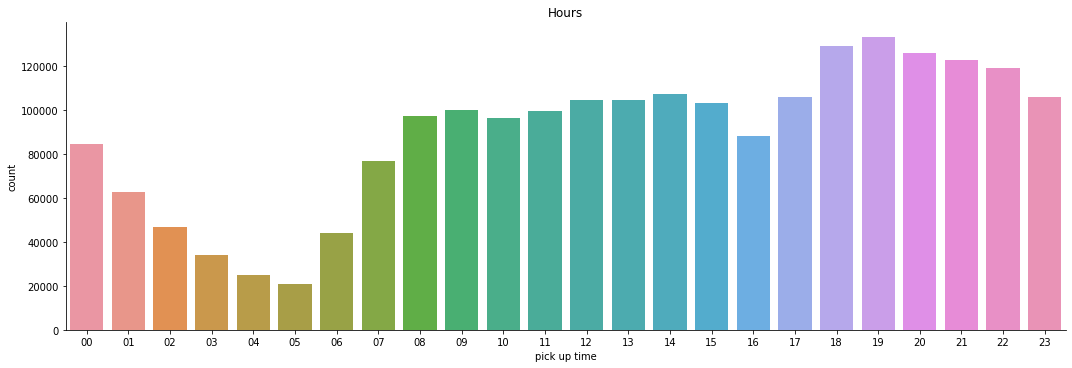

In [ ]:
# Кол-во поездок в зависимости от часа 'pick up time'
sns.catplot(x="pick up time", kind="count", data=data_train, height=5, aspect=3, 
            order=sorted(list(data_train['pick up time'].unique())));
sns.despine()

plt.title('Hours');
plt.show()
#Есть часы с низким и высоким спросом

In [ ]:
# переводим время в числовой формат

data_train["pick up time"] = pd.to_numeric(data_train["pick up time"])
data_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pick up time,month,year,date,Holiday,Pre_Holiday_day/saturday,Weekday,Manhattan_dist,airport_JK,airport_LG,airport_N
0,2009-12-10 15:37:00.00000020,6.1,2009-12-10 15:37:00 UTC,-73.969622,40.756973,-73.981152,40.759712,1,15,12,2009,2009-12-10,0,0,Thursday,0.857386,0,0,0
1,2013-01-29 12:26:00.000000154,9.0,2013-01-29 12:26:00 UTC,-73.992253,40.742657,-73.983597,40.755947,1,12,01,2013,2013-01-29,0,0,Tuesday,1.077763,0,0,0
2,2014-12-08 16:00:01.0000001,16.5,2014-12-08 16:00:01 UTC,-73.982800,40.745287,-74.014250,40.702935,1,16,12,2014,2014-12-08,0,0,Monday,3.359191,0,0,1
3,2011-06-09 00:53:00.00000066,5.7,2011-06-09 00:53:00 UTC,-73.983052,40.722588,-73.988022,40.733738,3,0,06,2011,2011-06-09,0,0,Thursday,0.948916,0,0,0
5,2015-04-19 22:21:12.0000005,8.0,2015-04-19 22:21:12 UTC,-73.985489,40.747280,-74.007675,40.740768,1,22,04,2015,2015-04-19,0,0,Sunday,1.683204,0,0,0


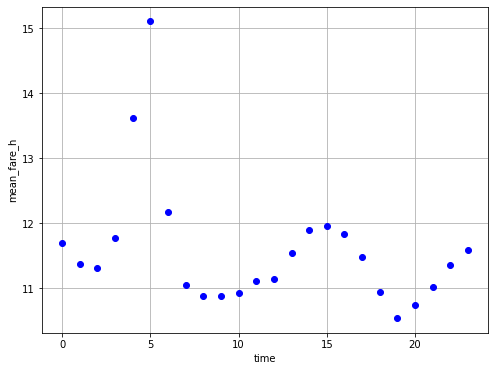

In [ ]:
# График средней стоимости по часам
dt_time=data_train[['pick up time','fare_amount']].groupby('pick up time').mean()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dt_time, 'bo') 

ax.grid(True)
ax.set_ylabel('mean_fare_h')
ax.set_xlabel('time');

# на графике что то похожее на sin, cos

## Группируем "месяц"

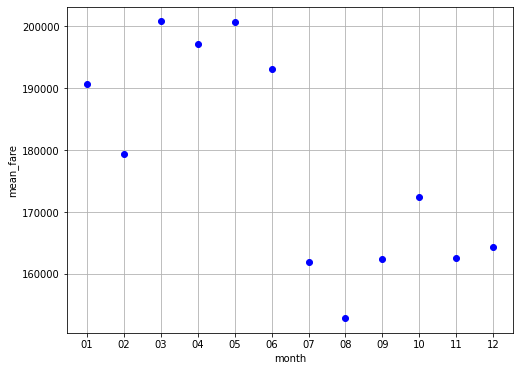

In [ ]:
# График количества поездок по месяцам
dt_month=data_train[['month','fare_amount']].groupby('month').count()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dt_month, 'bo') 

ax.grid(True)
ax.set_ylabel('mean_fare')
ax.set_xlabel('month');
    
# В первом полугодии люди чаще пользуются такси

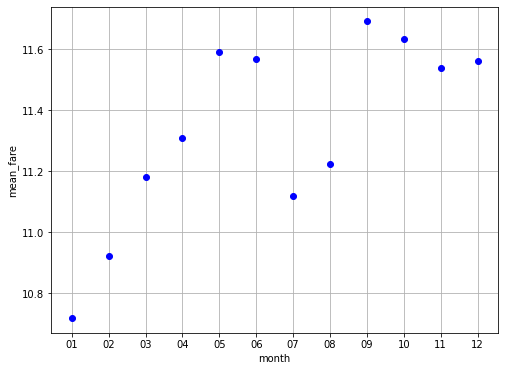

In [ ]:
# График стоимость - месяц
dt_month=data_train[['month','fare_amount']].groupby('month').mean()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dt_month, 'bo') 

ax.grid(True)
ax.set_ylabel('mean_fare')
ax.set_xlabel('month');

#Самые высокие цены в мае-июне и сентябрь-декабрь

In [ ]:
# "Месяц" группируем по сезонам - Зима, Весна, Лето, Осень:

data_train['season']=np.where(np.isin(data_train['month'] ,['12', '01', '02']), 'Winter', 
                     np.where(np.isin(data_train['month'] ,['03', '04', '05']), 'Spring',
                     np.where(np.isin(data_train['month'] ,['06', '07', '08']), 'Summer','Autumn')))
data_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pick up time,month,year,date,Holiday,Pre_Holiday_day/saturday,Weekday,Manhattan_dist,airport_JK,airport_LG,airport_N,season
0,2009-12-10 15:37:00.00000020,6.1,2009-12-10 15:37:00 UTC,-73.969622,40.756973,-73.981152,40.759712,1,15,12,2009,2009-12-10,0,0,Thursday,0.857386,0,0,0,Winter
1,2013-01-29 12:26:00.000000154,9.0,2013-01-29 12:26:00 UTC,-73.992253,40.742657,-73.983597,40.755947,1,12,01,2013,2013-01-29,0,0,Tuesday,1.077763,0,0,0,Winter
2,2014-12-08 16:00:01.0000001,16.5,2014-12-08 16:00:01 UTC,-73.982800,40.745287,-74.014250,40.702935,1,16,12,2014,2014-12-08,0,0,Monday,3.359191,0,0,1,Winter
3,2011-06-09 00:53:00.00000066,5.7,2011-06-09 00:53:00 UTC,-73.983052,40.722588,-73.988022,40.733738,3,0,06,2011,2011-06-09,0,0,Thursday,0.948916,0,0,0,Summer
5,2015-04-19 22:21:12.0000005,8.0,2015-04-19 22:21:12 UTC,-73.985489,40.747280,-74.007675,40.740768,1,22,04,2015,2015-04-19,0,0,Sunday,1.683204,0,0,0,Spring


In [ ]:
df_catboost=data_train[['fare_amount', 'passenger_count','pick up time','season','year', 'Holiday', 'Pre_Holiday_day/saturday', 'Weekday','Manhattan_dist', 
                 'airport_JK', 'airport_LG', 'airport_N']].copy()

In [ ]:
d1 = shape_begin
d2 = data_train.shape

print(f'Всего было удалено {round((d1[0]-d2[0])/d1[0]*100,2)}% событий от общей выборки.')

Всего было удалено 3.53% событий от общей выборки.


# 3) Кодирование признаков

In [ ]:
# кодируем "время" через синус и косинус (это масштабирует данные, сохраняя цикличность):
hours_in_day = 24

data_train['sin_hour'] = np.sin(2*np.pi*data_train['pick up time']/hours_in_day)
data_train['cos_hour'] = np.cos(2*np.pi*data_train['pick up time']/hours_in_day)


In [ ]:
data_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pick up time,month,year,date,Holiday,Pre_Holiday_day/saturday,Weekday,Manhattan_dist,airport_JK,airport_LG,airport_N,season,sin_hour,cos_hour
0,2009-12-10 15:37:00.00000020,6.1,2009-12-10 15:37:00 UTC,-73.969622,40.756973,-73.981152,40.759712,1,15,12,2009,2009-12-10,0,0,Thursday,0.857386,0,0,0,Winter,-7.071068e-01,-0.707107
1,2013-01-29 12:26:00.000000154,9.0,2013-01-29 12:26:00 UTC,-73.992253,40.742657,-73.983597,40.755947,1,12,01,2013,2013-01-29,0,0,Tuesday,1.077763,0,0,0,Winter,1.224647e-16,-1.000000
2,2014-12-08 16:00:01.0000001,16.5,2014-12-08 16:00:01 UTC,-73.982800,40.745287,-74.014250,40.702935,1,16,12,2014,2014-12-08,0,0,Monday,3.359191,0,0,1,Winter,-8.660254e-01,-0.500000
3,2011-06-09 00:53:00.00000066,5.7,2011-06-09 00:53:00 UTC,-73.983052,40.722588,-73.988022,40.733738,3,0,06,2011,2011-06-09,0,0,Thursday,0.948916,0,0,0,Summer,0.000000e+00,1.000000
5,2015-04-19 22:21:12.0000005,8.0,2015-04-19 22:21:12 UTC,-73.985489,40.747280,-74.007675,40.740768,1,22,04,2015,2015-04-19,0,0,Sunday,1.683204,0,0,0,Spring,-5.000000e-01,0.866025


In [ ]:
# Остальные признаки кодируем через OHC:
# Season, Year, Weekday

data_train = pd.get_dummies(data_train, columns=['season', 'year', 'Weekday'], prefix='', prefix_sep='') # prefix='', prefix_sep='' - убирает одинаковое начало закодированных столбцов
data_train.head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pick up time,month,date,Holiday,Pre_Holiday_day/saturday,Manhattan_dist,airport_JK,airport_LG,airport_N,sin_hour,cos_hour,Autumn,Spring,Summer,Winter,2009,2010,2011,2012,2013,2014,2015,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2009-12-10 15:37:00.00000020,6.1,2009-12-10 15:37:00 UTC,-73.969622,40.756973,-73.981152,40.759712,1,15,12,2009-12-10,0,0,0.857386,0,0,0,-7.071068e-01,-0.707107,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2013-01-29 12:26:00.000000154,9.0,2013-01-29 12:26:00 UTC,-73.992253,40.742657,-73.983597,40.755947,1,12,01,2013-01-29,0,0,1.077763,0,0,0,1.224647e-16,-1.000000,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,2014-12-08 16:00:01.0000001,16.5,2014-12-08 16:00:01 UTC,-73.982800,40.745287,-74.014250,40.702935,1,16,12,2014-12-08,0,0,3.359191,0,0,1,-8.660254e-01,-0.500000,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0


# 4) Создаем выборку для моделирования

In [ ]:
# Датафрейм для моделирования должен состоять из:

# fare_amount, passenger_count, Holiday, Pre_Holiday_day/saturday, Manhattan_dist, airport_JK, airport_LG, airport_N, sin_hour, cos_hour,
# Autumn,	Spring,	Summer,	Winter,	2009,	2010,	2011,	2012,	2013,	2014,	2015,	Friday,	Monday,	Saturday,	Sunday,	Thursday,	Tuesday,	Wednesday
# очищенный датафрейм:
df = data_train[['fare_amount', 'passenger_count', 'Holiday', 'Pre_Holiday_day/saturday', 'Manhattan_dist', 
                 'airport_JK', 'airport_LG', 'airport_N', 'sin_hour', 'cos_hour', 'Autumn',	'Spring',	'Summer',	
                 'Winter',	'2009',	'2010',	'2011',	'2012',	'2013',	'2014',	'2015',	'Friday',	'Monday',	'Saturday',	
                 'Sunday',	'Thursday',	'Tuesday',	'Wednesday']].copy()
df.head()

,fare_amount,passenger_count,Holiday,Pre_Holiday_day/saturday,Manhattan_dist,airport_JK,airport_LG,airport_N,sin_hour,cos_hour,Autumn,Spring,Summer,Winter,2009,2010,2011,2012,2013,2014,2015,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,6.1,1,0,0,0.857386,0,0,0,-7.071068e-01,-0.707107,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,9.0,1,0,0,1.077763,0,0,0,1.224647e-16,-1.000000,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,16.5,1,0,0,3.359191,0,0,1,-8.660254e-01,-0.500000,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,5.7,3,0,0,0.948916,0,0,0,0.000000e+00,1.000000,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
5,8.0,1,0,0,1.683204,0,0,0,-5.000000e-01,0.866025,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


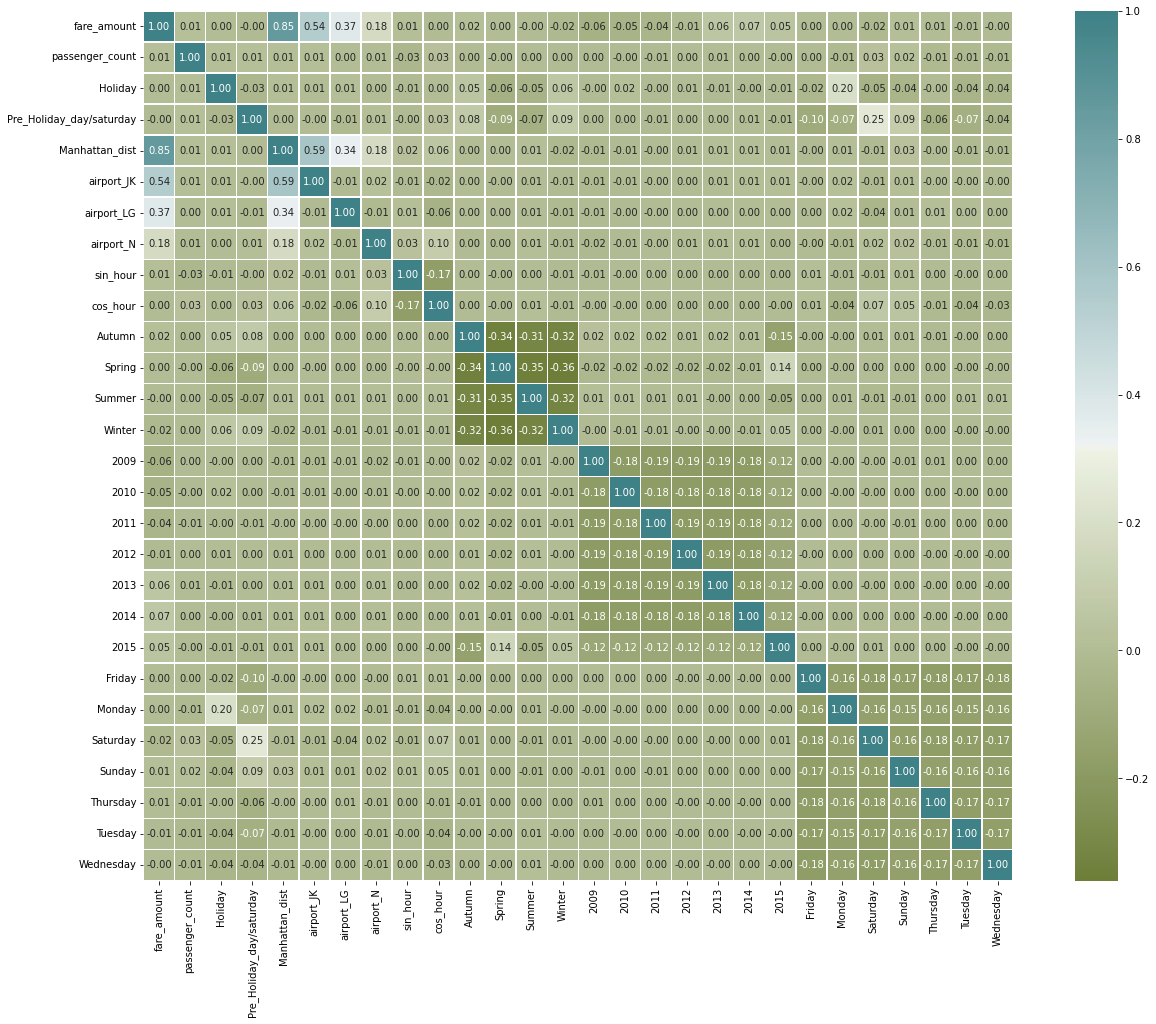

In [ ]:
# Матрица корреляции:

plt.figure(figsize=(22,16))

corr = df.corr()

sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',\
            mask=np.zeros_like(corr, dtype=np.bool), \
            cmap=sns.diverging_palette(100,200,as_cmap=True), square=True)

Дистанция и признаки аэропортов достаточно сильно коррелируют с целевой переменной

# 5) МОДЕЛЬ

In [ ]:
# ДАТАФРЕЙМ для моделей:
df.head(5)

,fare_amount,passenger_count,Holiday,Pre_Holiday_day/saturday,Manhattan_dist,airport_JK,airport_LG,airport_N,sin_hour,cos_hour,Autumn,Spring,Summer,Winter,2009,2010,2011,2012,2013,2014,2015,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,6.1,1,0,0,0.857386,0,0,0,-7.071068e-01,-0.707107,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,9.0,1,0,0,1.077763,0,0,0,1.224647e-16,-1.000000,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,16.5,1,0,0,3.359191,0,0,1,-8.660254e-01,-0.500000,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,5.7,3,0,0,0.948916,0,0,0,0.000000e+00,1.000000,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
5,8.0,1,0,0,1.683204,0,0,0,-5.000000e-01,0.866025,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [ ]:
#Делим на зависимую и независимые переменные
y = df['fare_amount']
X = df.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

***Для начало изучим качество предсказания на моделях линейной регрессии***

## LinearRegression

In [ ]:
# Т.к. значения данных расположены близко друг к другу - дополнительно масштабирование не требуется
model_LR = LinearRegression()

parameters = {'fit_intercept':[True,False]}
lr_cv = GridSearchCV(model_LR, parameters, cv=5, 
                    scoring = 'neg_root_mean_squared_error')

%time lr_cv.fit(X_train, y_train)

print('best_score:', -lr_cv.best_score_)
print('best_estimator:', lr_cv.best_params_)

CPU times: user 28.8 s, sys: 4.28 s, total: 33.1 s
Wall time: 21.3 s
best_score: 4.796376737100303
best_estimator: {'fit_intercept': False}


In [ ]:
model_LR = LinearRegression(fit_intercept= False)

%time model_LR.fit(X_train, y_train)

ypred_train = model_LR.predict(X_train)
ypred_test = model_LR.predict(X_test)

print('RMSE train =', mean_squared_error(y_train, ypred_train)**0.5)
print('RMSE test =',  mean_squared_error(y_test, ypred_test)**0.5)

print('Cross-Val =', (-cross_val_score(model_LR, X, y, cv=5, scoring='neg_mean_squared_error').mean())**0.5)

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model_LR.coef_))], axis = 1)
print('w0 =', model_LR.intercept_)
coefficients

CPU times: user 2.91 s, sys: 273 ms, total: 3.18 s
Wall time: 1.99 s
RMSE train = 4.796519715585786
RMSE test = 4.84945611078192
Cross-Val = 4.8081866183555615
w0 = 4.664502857504133


,0,0
0,passenger_count,0.040769
1,Holiday,-0.403936
2,Pre_Holiday_day/saturday,-0.077616
3,Manhattan_dist,2.415299
4,airport_JK,6.713702
5,airport_LG,6.570816
6,airport_N,1.215623
7,sin_hour,-0.214346
8,cos_hour,-0.518875
9,Autumn,0.347648


**Линейная регрессия** с подобранными гиперпараметрами на кросс-валидации

**Качество** - 4.8

**Гиперпараметры:**
>'fit_intercept': False

In [ ]:
# Drop: cos, Summer, Sunday

# df = df.drop(['cos_hour', 'Summer', 'Sunday'], axis=1, inplace = True)
# Удаление столбцов, которые не коррелируют с целевой переменной привело к увеличению RMSE на 0.01. Оставляем исходный датафрем.

In [ ]:
# не дало значительного снижения RMSE

# new_data = df.copy()
# new_data['new_col'] = np.log1p(new_data['Manhattan_dist'] + new_data['sin_hour']) 
#логарифмирование расстояния улучшило cross val на 0.016, RMSE на train и test = 4.79


Далее расчет продолжаем по датафрейму "df".

Добавление тригонометрической функции (в 'new_data') не дало существенных изменений.

## Lasso

In [ ]:
model_Lasso = Lasso()

alpha = np.linspace(0.1, 10, 100)
parameters = {'alpha':alpha}

lasso_cv = GridSearchCV(model_Lasso, parameters, cv=5, 
                    scoring = 'neg_root_mean_squared_error')

%time lasso_cv.fit(X_train, y_train)

print('best_score:', -lasso_cv.best_score_)
print('best_parameters:', lasso_cv.best_params_)

CPU times: user 7min 56s, sys: 1min 30s, total: 9min 26s
Wall time: 7min 2s
best_score: 4.958793903706455
best_parameters: {'alpha': 0.1}


In [ ]:
model_Lasso = Lasso(alpha = 0.1, random_state=123)
%time model_Lasso.fit(X_train, y_train)

ypred_train = model_Lasso.predict(X_train)
ypred_test = model_Lasso.predict(X_test)

print('RMSE train =', mean_squared_error(y_train, ypred_train)**0.5)
print('RMSE test =',  mean_squared_error(y_test, ypred_test)**0.5)
print('Cross-Val =', (-cross_val_score(model_Lasso, X, y, cv=5, scoring='neg_mean_squared_error').mean())**0.5)

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model_Lasso.coef_))], axis = 1)
print('w0 =', model_Lasso.intercept_)
coefficients

# L1-регуляризация зануляет некоторые веса и таким образом производит отбор признаков

# КАЧЕСТВО УХУДШИЛОСЬ

CPU times: user 2.44 s, sys: 180 ms, total: 2.62 s
Wall time: 1.55 s
RMSE train = 4.959181068351516
RMSE test = 5.011302584805551
Cross-Val = 4.9700386379496715
w0 = 4.108069844007444


,0,0
0,passenger_count,0.000000
1,Holiday,-0.000000
2,Pre_Holiday_day/saturday,-0.000000
3,Manhattan_dist,2.732104
4,airport_JK,0.000000
5,airport_LG,1.633847
6,airport_N,0.000000
7,sin_hour,-0.000000
8,cos_hour,-0.405792
9,Autumn,0.000000


**Линейная регрессия с L1 регуляризацией** с подобранными гиперпараметрами на кросс-валидации 

 **Качество** - 4.97

 **Гиперпараметры:**
 >'alpha': 0.1  

## Ridge

In [ ]:
model_Ridge = Ridge()

alpha = np.logspace(-2, 6, 100)
parameters = {'alpha':alpha}

ridge_cv = GridSearchCV(model_Ridge, parameters, cv=5, 
                    scoring = 'neg_root_mean_squared_error')
%time ridge_cv.fit(X, y)

print('best_score:', -ridge_cv.best_score_)
print('best_parameters:', ridge_cv.best_params_)

CPU times: user 8min 30s, sys: 2min 7s, total: 10min 38s
Wall time: 7min 47s
best_score: 4.807587751545091
best_parameters: {'alpha': 62.802914418342596}


In [ ]:
model_Ridge = Ridge(alpha=62.8, random_state=123)
%time model_Ridge.fit(X_train, y_train)

ypred_train = model_Ridge.predict(X_train)
ypred_test = model_Ridge.predict(X_test)

print('RMSE train =', mean_squared_error(y_train, ypred_train)**0.5)
print('RMSE test =',  mean_squared_error(y_test, ypred_test)**0.5)
print('Cross-Val =', (-cross_val_score(model_Ridge, X, y, cv=5, scoring='neg_mean_squared_error').mean())**0.5)

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model_Ridge.coef_))], axis = 1)
print('w0 =', model_Ridge.intercept_)
coefficients

# Ridge регрессия не зануляет веса (они могут быть очень маленькими, но ненулевыми)

# КАЧЕСТВО УХУДШИЛОСЬ

CPU times: user 605 ms, sys: 159 ms, total: 764 ms
Wall time: 537 ms
RMSE train = 4.7965203690189036
RMSE test = 4.849455492671902
Cross-Val = 4.808186613991817
w0 = 4.66325960946341


,0,0
0,passenger_count,0.040781
1,Holiday,-0.403402
2,Pre_Holiday_day/saturday,-0.077564
3,Manhattan_dist,2.416138
4,airport_JK,6.694206
5,airport_LG,6.559590
6,airport_N,1.214287
7,sin_hour,-0.214466
8,cos_hour,-0.519231
9,Autumn,0.347564


**Линейная регрессия с L2 регуляризацией** с подобранными гиперпараметрами на кросс-валидации 

**Качество** - 4.81

**Гиперпараметры:** 

>'alpha': 62.8

## ElasticNet (Lassо + Ridge)

In [ ]:
model_EN = ElasticNet()

alpha = np.logspace(-2, 6, 100)
l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
parameters = {'alpha':alpha,'l1_ratio':l1_ratio}

en_cv = GridSearchCV(model_EN, parameters, cv=5, 
                    scoring = 'neg_root_mean_squared_error')

%time en_cv.fit(X_train, y_train)

print('best_score:', -en_cv.best_score_)
print('best_parameters:', en_cv.best_params_)

CPU times: user 2h 4min 6s, sys: 16min 16s, total: 2h 20min 23s
Wall time: 1h 33min 48s
best_score: 4.799429031873183
best_parameters: {'alpha': 0.01, 'l1_ratio': 1}


In [ ]:
model_EN = ElasticNet(l1_ratio=1.0, alpha=0.01, random_state=123, 
                      max_iter=10000, tol=0.01)

%time model_EN.fit(X_train, y_train)

y_pred_train = model_EN.predict(X_train)
y_pred_test = model_EN.predict(X_test)

print('RMSE train =', mean_squared_error(y_train, y_pred_train)**0.5)
print('RMSE test =',  mean_squared_error(y_test, y_pred_test)**0.5)
print('Cross-Val =', (-cross_val_score(model_EN, X, y, cv=5, scoring='neg_mean_squared_error').mean())**0.5)

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model_EN.coef_))], axis = 1)
print('w0 =', model_EN.intercept_)
coefficients

CPU times: user 2.02 s, sys: 185 ms, total: 2.2 s
Wall time: 1.33 s
RMSE train = 4.799774290384224
RMSE test = 4.852831931586119
Cross-Val = 4.811397722739143
w0 = 4.897988113241113


,0,0
0,passenger_count,0.034273
1,Holiday,-0.000000
2,Pre_Holiday_day/saturday,-0.000000
3,Manhattan_dist,2.461226
4,airport_JK,5.710298
5,airport_LG,5.993014
6,airport_N,1.072642
7,sin_hour,-0.193468
8,cos_hour,-0.515907
9,Autumn,0.381205


**Линейная регрессия с L1-L2 регуляризацией** с подобранными гиперпараметрами 

**Качество** - 4.81 

**Гиперпараметры:**
>'alpha': 0.01

>'l1_ratio': 1 

***Теперь изучим качество более сложных моделей - лесов и их ансамблей***

In [ ]:
#Функция для графика важности переменных
#Нужна для визуализации результатов будущих моделей
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    plt.style.use("bmh")
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## RandomForest

In [ ]:
#Попробуем использовать модель случайного леса
model_RF=RandomForestRegressor()

max_features = [9] #берем треть от всех признаков для каждого дерева
max_depth = [5] #оставляем в листе максимум 5 элементов
oob_score = [True]
criterion = ['squared_error']
random_state = [123]
n_jobs=[-1]
max_samples = np.arange(0.1,1,0.1)
n_estimators = range(5,50,5)

parameters = { 'max_samples':max_samples, 'n_estimators': n_estimators,
              'max_depth': max_depth, 'max_features': max_features, 
              'criterion':criterion, 'random_state' : random_state, 
              'n_jobs':n_jobs}

rf_cv = GridSearchCV(model_RF, parameters, cv=5, 
                    scoring = 'neg_root_mean_squared_error')
rf_cv.fit(X_train, y_train)


print('best_score:', -rf_cv.best_score_)
print('best_parameters:', rf_cv.best_params_)
#Warning! Параметры подбираются час с лишним. 
#Лучше перейти сразу к следующей ячейке

In [ ]:
model_RF = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='squared_error',
                      max_depth=5, max_features=9, max_leaf_nodes=None,
                      max_samples=0.3, min_impurity_decrease=0.0, 
                      min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

%time model_RF.fit(X_train, y_train)

y_pred_train = model_RF.predict(X_train)
y_pred_test = model_RF.predict(X_test)

print('RMSE train =', mean_squared_error(y_train, y_pred_train)**0.5)
print('RMSE test =',  mean_squared_error(y_test, y_pred_test)**0.5)
# КАЧЕСТВО ЛУЧШЕ, чем в регрессионных моделях

CPU times: user 36.1 s, sys: 71.7 ms, total: 36.2 s
Wall time: 19 s
RMSE train = 4.55942413999931
RMSE test = 4.630747978155475


**Случайный лес** с подобранными гиперпараметрами

**Качество** - 4.56

**Гиперпараметры:**

>'max_samples': 0.3

>'n_estimators':30

>'max_depth': 5
 
>'max_features': 9


<Figure size 3600x504 with 0 Axes>

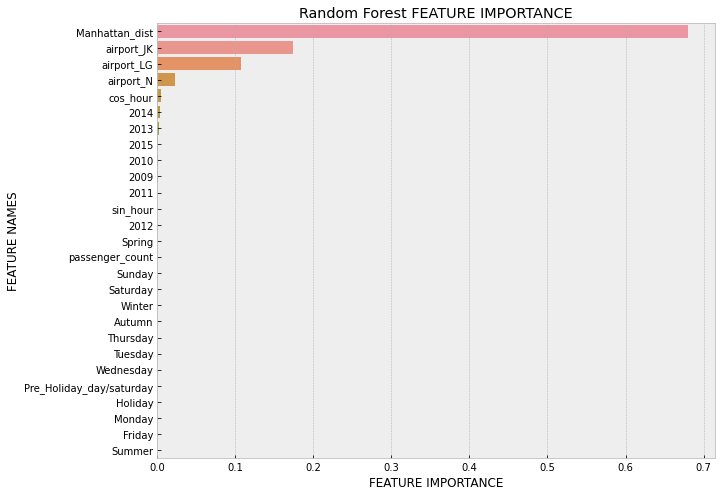

In [ ]:
plt.figure(figsize = (50, 7))
plot_feature_importance(model_RF.feature_importances_,X_train.columns,'Random Forest ');
#Самые важные переменные в модели леса - это дистанция и признаки аэропорта

## XGBOOST

In [ ]:
model_GBR = GradientBoostingRegressor(criterion = 'squared_error', 
                                      random_state=0)

%time model_GBR.fit(X_train, y_train)

ypred_train = model_GBR.predict(X_train)
ypred_test = model_GBR.predict(X_test)

print('RMSE train =', mean_squared_error(y_train, ypred_train)**0.5)
print('RMSE test =',  mean_squared_error(y_test, ypred_test)**0.5)

CPU times: user 5min 45s, sys: 633 ms, total: 5min 46s
Wall time: 5min 44s
RMSE train = 3.9460982655675676
RMSE test = 4.032086169527151


In [ ]:
model_XGB = XGBRegressor()

nthread = [4] 
objective = ['reg:linear']
learning_rate = [.03, 0.05, .07]
max_depth = [5, 6, 7]
min_child_weight = [4]
silent=[1]
subsample = [0.7]
colsample_bytree = [0.7]
n_estimators = [500]
criterion = ['squared_error']

parameters = {'criterion':criterion, 'nthread':nthread, 'objective': objective,
              'learning_rate': learning_rate, 'max_depth': max_depth, 
              'min_child_weight':min_child_weight, 'silent':silent, 
              'subsample':subsample,'colsample_bytree':colsample_bytree,
              'n_estimators':n_estimators}

xgb_cv = GridSearchCV(model_XGB, parameters, cv = 3, n_jobs = -1, verbose=True)

xgb_cv.fit(X_train, y_train)


print('best_score:', -xgb_cv.best_score_)
print('best_parameters:', xgb_cv.best_params_)

In [ ]:
model_XGB = XGBRegressor(criterion = 'squared_error', colsample_bytree= 0.7, 
                         learning_rate = 0.03, max_depth = 6, 
                         min_child_weight = 4, n_estimators = 500, nthread = 4, 
                         objective = 'reg:linear', silent = 1, subsample = 0.7, 
                         random_state=123)

%time model_XGB.fit(X_train, y_train)

ypred_train = model_XGB.predict(X_train)
ypred_test = model_XGB.predict(X_test)

print('RMSE train =', mean_squared_error(y_train, ypred_train)**0.5)
print('RMSE test =',  mean_squared_error(y_test, ypred_test)**0.5)

CPU times: user 39min 17s, sys: 4.67 s, total: 39min 22s
Wall time: 20min 31s
RMSE train = 3.7754528939387137
RMSE test = 3.939476036904156


**XGBoosting** с подобранными гиперпараметрами

**Качество** - 3.78

**Гиперпараметры:**

'colsample_bytree': 0.7 

'learning_rate': 0.03

'max_depth': 6

'min_child_weight': 4

'n_estimators': 500

'nthread': 4

'objective': 'reg:linear' 

'silent': 1

'subsample': 0.7

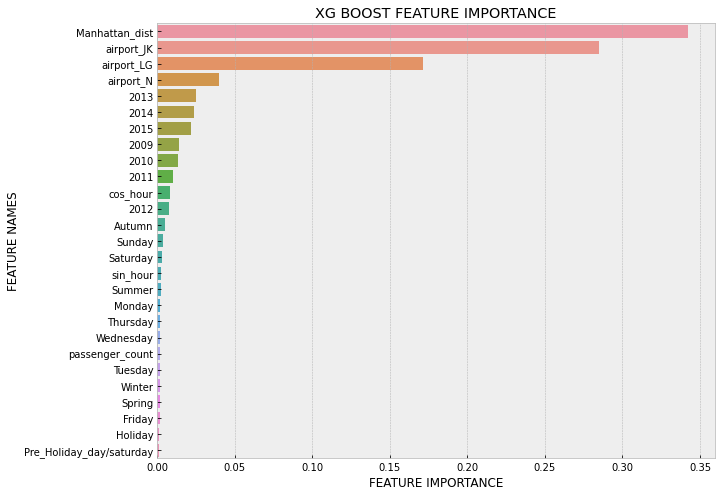

In [ ]:
plot_feature_importance(model_XGB.feature_importances_,X_train.columns,'XG BOOST ')


## CATBOOST

In [ ]:
# подготовка данных для кодирования категориальных признаков
#создаем dataset без кодирования для catboost
y_catboost = df_catboost['fare_amount']
X_catboost = df_catboost.iloc[:,1:]

X_catboost_train, X_catboost_test, y_catboost_train, y_catboost_test = train_test_split(X_catboost, y_catboost, test_size=0.2, random_state=123)

In [ ]:
cat_features=['pick up time','season','year','Weekday']

In [ ]:
X_catboost_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1710981 entries, 1632860 to 801790
Data columns (total 11 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   passenger_count           int64  
 1   pick up time              int64  
 2   season                    object 
 3   year                      object 
 4   Holiday                   int64  
 5   Pre_Holiday_day/saturday  int64  
 6   Weekday                   object 
 7   Manhattan_dist            float64
 8   airport_JK                int64  
 9   airport_LG                int64  
 10  airport_N                 int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 156.6+ MB


###First catboost model (with processing of categorical features) without hyperparams

In [ ]:
model_CBa_nonHP = CatBoostRegressor(iterations=250,
                          learning_rate=0.5,
                          loss_function='RMSE',
                          random_seed=123)

model_CBa_nonHP.fit(X_catboost_train, y_catboost_train, cat_features=cat_features, eval_set=(X_catboost_test, y_catboost_test), verbose=10)

0:	learn: 6.2751864	test: 6.3440894	best: 6.3440894 (0)	total: 2.1s	remaining: 8m 41s
10:	learn: 4.0672695	test: 4.1301111	best: 4.1301111 (10)	total: 16.5s	remaining: 5m 58s
20:	learn: 4.0149962	test: 4.0823879	best: 4.0823879 (20)	total: 31.5s	remaining: 5m 43s
30:	learn: 3.9907506	test: 4.0619442	best: 4.0619442 (30)	total: 44.7s	remaining: 5m 15s
40:	learn: 3.9709212	test: 4.0450825	best: 4.0450825 (40)	total: 58.7s	remaining: 4m 59s
50:	learn: 3.9628662	test: 4.0395828	best: 4.0395828 (50)	total: 1m 12s	remaining: 4m 43s
60:	learn: 3.9546394	test: 4.0390084	best: 4.0390084 (60)	total: 1m 25s	remaining: 4m 24s
70:	learn: 3.9478066	test: 4.0352323	best: 4.0352323 (70)	total: 1m 37s	remaining: 4m 6s
80:	learn: 3.9398136	test: 4.0332987	best: 4.0332987 (80)	total: 1m 49s	remaining: 3m 47s
90:	learn: 3.9319081	test: 4.0314800	best: 4.0314800 (90)	total: 2m 3s	remaining: 3m 35s
100:	learn: 3.9265377	test: 4.0287056	best: 4.0287056 (100)	total: 2m 16s	remaining: 3m 21s
110:	learn: 3.9220

**CatBoost c автоматической обработкой категориальных признаков** без подбора гиперпараметров 

**Качество** - 4.03

###GridSearch CV with processing of categorical features in catboost

In [ ]:
model_CBa_HP =CatBoostRegressor(loss_function='RMSE', )

random_strength=[0,1]
l2_leaf_reg=np.arange(1, 12, 2)
depth= np.arange(4, 12, 2)
learning_rate = [0.5]
iterations=[150]
random_seed=[123]
loss_function = ['RMSE']

parameters = {'random_strength':random_strength, 'l2_leaf_reg':l2_leaf_reg, 
              'depth': depth, 'learning_rate': learning_rate, 
              'iterations':iterations, 'random_seed':random_seed, 
              'loss_function':loss_function}

cba_cv = GridSearchCV(model_CBa_HP, parameters, cv = 3, n_jobs = -1, 
                     scoring = 'neg_root_mean_squared_error')

cba_cv.fit(X_catboost_train, y_catboost_train, cat_features=cat_features, verbose=10)


print('best_score:', -cba_cv.best_score_)
print('best_parameters:', cba_cv.best_params_)

In [ ]:
#Увеличивает число итераций, пропорционально уменьшаем learning_rate
model_CBa_HP = CatBoostRegressor(iterations=1500,
                           learning_rate=0.05,
                           depth=6,
                           l2_leaf_reg=9,
                           random_strength=0,
                           loss_function='RMSE', 
                           random_seed=123)

%time model_CBa_HP.fit(X_catboost_train, y_catboost_train, cat_features=cat_features, verbose=100)

ypred_train = model_CBa_HP.predict(X_catboost_train)
ypred_test = model_CBa_HP.predict(X_catboost_test)

print('RMSE train =', mean_squared_error(y_catboost_train, ypred_train)**0.5)
print('RMSE test =',  mean_squared_error(y_catboost_test, ypred_test)**0.5)

0:	learn: 9.2136682	total: 1.68s	remaining: 41m 59s
100:	learn: 4.0547835	total: 2m 13s	remaining: 30m 56s
200:	learn: 3.9940339	total: 4m 21s	remaining: 28m 8s
300:	learn: 3.9716239	total: 6m 24s	remaining: 25m 30s
400:	learn: 3.9589457	total: 8m 14s	remaining: 22m 34s
500:	learn: 3.9518375	total: 10m	remaining: 19m 58s
600:	learn: 3.9453681	total: 11m 43s	remaining: 17m 31s
700:	learn: 3.9381759	total: 13m 31s	remaining: 15m 25s
800:	learn: 3.9326546	total: 15m 32s	remaining: 13m 33s
900:	learn: 3.9277129	total: 17m 29s	remaining: 11m 38s
1000:	learn: 3.9227759	total: 19m 26s	remaining: 9m 41s
1100:	learn: 3.9189890	total: 21m 28s	remaining: 7m 47s
1200:	learn: 3.9152313	total: 23m 31s	remaining: 5m 51s
1300:	learn: 3.9118244	total: 25m 31s	remaining: 3m 54s
1400:	learn: 3.9094707	total: 27m 24s	remaining: 1m 56s
1499:	learn: 3.9064406	total: 29m 18s	remaining: 0us
CPU times: user 56min 41s, sys: 10.6 s, total: 56min 52s
Wall time: 29min 32s
RMSE train = 3.913064282807298
RMSE test =

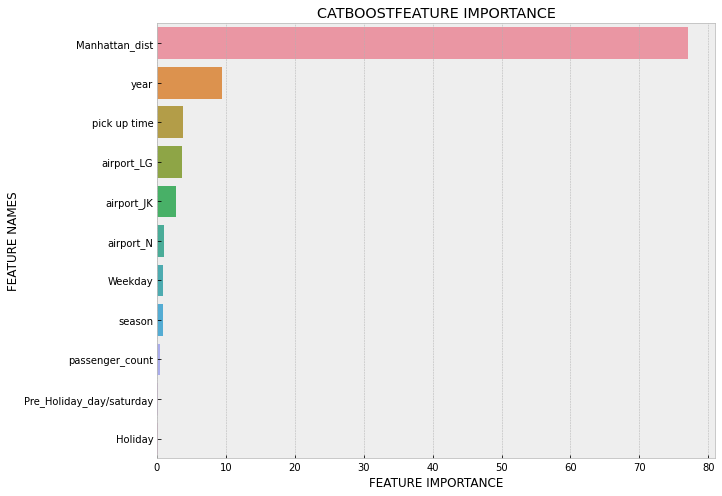

In [ ]:
plot_feature_importance(model_CBa_HP.get_feature_importance(), X_catboost_train.columns,'CATBOOST')

**CatBoost c автоматической обработкой категориальных признаков** и подобранными гиперпараметрами 

**Качество** - 3,91

**Гиперпараметры:**

>'iterations':1500

>'learning_rate':0.05

>'depth':6

>'l2_leaf_reg':9

>'random_strength':0

###Second catboost model (with manual processing of categorical features) without hyperparams

In [ ]:
model_CBm_nonHP = CatBoostRegressor(iterations=250,
                          learning_rate=0.5,
                          loss_function='RMSE',
                          random_seed=123)

model_CBm_nonHP.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=10)

0:	learn: 6.2716536	test: 6.3405605	best: 6.3405605 (0)	total: 219ms	remaining: 54.6s
10:	learn: 4.0799626	test: 4.1397070	best: 4.1397070 (10)	total: 2.35s	remaining: 51.1s
20:	learn: 4.0094538	test: 4.0762371	best: 4.0762371 (20)	total: 4.44s	remaining: 48.4s
30:	learn: 3.9771986	test: 4.0538587	best: 4.0538587 (30)	total: 6.55s	remaining: 46.3s
40:	learn: 3.9611087	test: 4.0447131	best: 4.0447131 (40)	total: 8.64s	remaining: 44s
50:	learn: 3.9472326	test: 4.0389825	best: 4.0389825 (50)	total: 10.7s	remaining: 41.8s
60:	learn: 3.9353835	test: 4.0349847	best: 4.0349847 (60)	total: 12.7s	remaining: 39.5s
70:	learn: 3.9273274	test: 4.0329666	best: 4.0321424 (68)	total: 14.9s	remaining: 37.5s
80:	learn: 3.9186282	test: 4.0311078	best: 4.0293654 (77)	total: 16.9s	remaining: 35.3s
90:	learn: 3.9105211	test: 4.0328437	best: 4.0293654 (77)	total: 19s	remaining: 33.2s
100:	learn: 3.9035996	test: 4.0327072	best: 4.0293654 (77)	total: 21.1s	remaining: 31.1s
110:	learn: 3.8982102	test: 4.0322684

**CatBoost c ручной обработкой категориальных признаков** без подбора гиперпараметров

**Качество** - 4.03

###GridSearch CV with manual processing of categorical features

In [ ]:
model_CBm_HP =CatBoostRegressor(loss_function='RMSE', )

random_strength=[0,1]
l2_leaf_reg=np.arange(1, 12, 2)
depth= np.arange(6, 12, 2)
learning_rate = [0.5]
iterations=[77]
random_seed=[123]
loss_function = ['RMSE']

parameters = {'random_strength':random_strength, 'l2_leaf_reg':l2_leaf_reg, 
              'depth': depth, 'learning_rate': learning_rate, 
              'iterations':iterations, 'random_seed':random_seed, 
              'loss_function':loss_function}

cbm_cv = GridSearchCV(model_CBm_HP, parameters, cv = 5, n_jobs = -1, 
                     scoring = 'neg_root_mean_squared_error')

cbm_cv.fit(X_train, y_train)


print('best_score:', -cbm_cv.best_score_)
print('best_parameters:', cbm_cv.best_params_)

In [ ]:
model_CBm_HP = CatBoostRegressor(iterations=770,
                           learning_rate=0.05,
                           depth=6,
                           l2_leaf_reg=9,
                           random_strength=1,
                           loss_function='RMSE', 
                           random_seed=63)

%time model_CBm_HP.fit(X_train, y_train, verbose=100)

ypred_train = model_CBm_HP.predict(X_train)
ypred_test = model_CBm_HP.predict(X_test)

print('RMSE train =', mean_squared_error(y_train, ypred_train)**0.5)
print('RMSE test =',  mean_squared_error(y_test, ypred_test)**0.5)

0:	learn: 9.2150835	total: 261ms	remaining: 3m 20s
100:	learn: 4.0621563	total: 21.8s	remaining: 2m 24s
200:	learn: 3.9892802	total: 43.2s	remaining: 2m 2s
300:	learn: 3.9611811	total: 1m 4s	remaining: 1m 40s
400:	learn: 3.9435583	total: 1m 25s	remaining: 1m 18s
500:	learn: 3.9312906	total: 1m 46s	remaining: 57.3s
600:	learn: 3.9215108	total: 2m 7s	remaining: 35.9s
700:	learn: 3.9137827	total: 2m 28s	remaining: 14.6s
769:	learn: 3.9089835	total: 2m 43s	remaining: 0us
CPU times: user 5min 17s, sys: 1.53 s, total: 5min 18s
Wall time: 2min 44s
RMSE train = 3.9089834940420216
RMSE test = 4.020514133107909


**CatBoost c ручной обработкой категориальных признаков** и подобранными гиперпараметрами 

**Качество** - 3.91

**Гиперпараметры:**

>'l2_leaf_reg': 9

>'depth': 6

>'learning_rate': 0.05

>'iterations': 770


>'loss_function': 'RMSE'

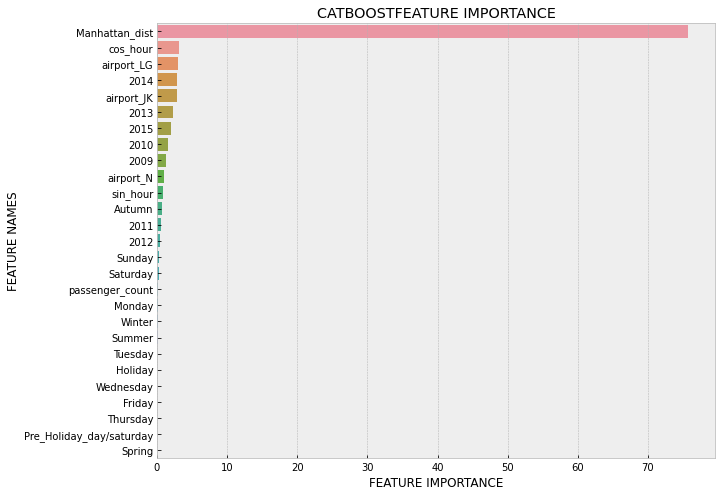

In [ ]:
plot_feature_importance(model_CBm_HP.get_feature_importance(),X_train.columns,'CATBOOST')

## LightGBM

In [ ]:
model_LGB =LGBMRegressor()

n_estimators=[20, 100]
max_depth=[3,8]
num_leaves= [10,20,60,100]
learning_rate = [0.01, 0.1, 0,5]
min_split_gain=[0.3, 0.4]
subsample=[0.7, 0.8, 0.9]
random_state =[123]

parameters = {'n_estimators':n_estimators, 'max_depth':max_depth, 
              'num_leaves': num_leaves, 'learning_rate': learning_rate, 
              'min_split_gain':min_split_gain, 'random_state':random_state, 
              'subsample':subsample, 'random_state':random_state}

lgb_cv = GridSearchCV(model_LGB, parameters, cv = 5, n_jobs = -1, 
                     scoring = 'neg_root_mean_squared_error')

lgb_cv.fit(X_train, y_train)


print('best_score:', -lgb_cv.best_score_)
print('best_parameters:', lgb_cv.best_params_)

In [ ]:
model_LGB = LGBMRegressor(learning_rate=0.1, max_depth=8, min_split_gain=0.4, 
                        n_estimators=100, num_leaves= 60, subsample=0.7)

%time model_LGB.fit(X_train, y_train, verbose=False)

ypred_test = model_LGB.predict(X_test)
ypred_train = model_LGB.predict(X_train)

print('RMSE train =', mean_squared_error(y_train, ypred_train)**0.5)
print('RMSE test =',  mean_squared_error(y_test, ypred_test)**0.5)

CPU times: user 37 s, sys: 1.81 s, total: 38.8 s
Wall time: 21.7 s
RMSE train = 3.8969317686980416
RMSE test = 4.0198296108812395


**LightGBM** с подобранными гиперпараметрами

**Качество** - 3.9

**Гиперпараметры:**

>'learning_rate': 0.1, 

>'max_depth': 8, 

>'min_split_gain': 0.4, 

>'n_estimators': 100, 

>'num_leaves': 60, 

>'subsample': 0.7

# 6) Подготовка выборки Test

Подготовим тестовые данные по аналогии с тренировочными

In [ ]:
data_test = data_test_full
# размер датасета:
data_test.shape
data_test

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,date,pick up time,month,year,Holiday,Pre_Holiday_day/saturday,Weekday,season,Manhattan_dist,airport_JK,airport_LG,airport_N,sin_hour,cos_hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,2015-01-27,13,01,2015,0,0,Tuesday,Winter,1.714966,0,0,0,-2.588190e-01,-0.965926
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,2015-01-27,13,01,2015,0,0,Tuesday,Winter,1.624331,0,0,1,-2.588190e-01,-0.965926
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,2011-10-08,11,10,2011,0,1,Saturday,Autumn,0.424367,0,0,0,2.588190e-01,-0.965926
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,2012-12-01,21,12,2012,0,0,Saturday,Winter,1.335761,0,0,0,-7.071068e-01,0.707107
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,2012-12-01,21,12,2012,0,0,Saturday,Winter,3.814364,0,0,0,-7.071068e-01,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51 UTC,-73.968124,40.796997,-73.955643,40.780388,6,2015-05-10,12,05,2015,0,0,Sunday,Spring,1.314490,0,0,0,1.224647e-16,-1.000000
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51 UTC,-73.945511,40.803600,-73.960213,40.776371,6,2015-01-12,17,01,2015,0,0,Monday,Winter,2.267328,0,0,0,-9.659258e-01,-0.258819
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15 UTC,-73.991600,40.726608,-73.789742,40.647011,6,2015-04-19,20,04,2015,0,0,Sunday,Spring,15.862058,1,0,0,-8.660254e-01,0.500000
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19 UTC,-73.985573,40.735432,-73.939178,40.801731,6,2015-01-31,1,01,2015,0,0,Saturday,Winter,5.313961,0,0,0,2.588190e-01,0.965926


Добавление новых столбцов

In [ ]:
#Части Дата-Время
data_test['date'] = data_test['pickup_datetime'].str[:10]
data_test['pick up time'] = data_test['pickup_datetime'].str[11:13] 
data_test['month'] = data_test['pickup_datetime'].str[5:7]
data_test['year'] = data_test['pickup_datetime'].str[:4]

data_test['date'] = pd.to_datetime(data_test['date']) 
data_test["pick up time"] = pd.to_numeric(data_test["pick up time"])

#Праздничные-предпразничные дни и субботы, а так же дни недели
data_test['Holiday']=data_test['date'].isin(holidays['Date'])*1
data_test['Pre_Holiday_day/saturday']=((
        (data_test['date'].isin(holidays['Pre_Date'])) & 
        (data_test['date'].isin(holidays['Date'])==False)) | 
        (data_test['date'].isin(holidays['Pre_Saturday'])))*1
data_test['Weekday']=data_test.date.dt.day_name()

#Сезоны
data_test['season']=np.where(np.isin(data_test['month'] ,['12', '01', '02']), 'Winter', 
                     np.where(np.isin(data_test['month'] ,['03', '04', '05']), 'Spring',
                     np.where(np.isin(data_test['month'] ,['06', '07', '08']), 'Summer','Autumn')))

#Расстояние
a1 = data_test['pickup_latitude']
b1 = data_test['pickup_longitude']
a2 = data_test['dropoff_latitude']
b2 = data_test['dropoff_longitude']
vector_degr = abs(a1 - a2) + abs(b1 - b2)
lat = abs(a1 - a2)*69
lon = abs(b1 - b2)*50
vector_miles = lat + lon
Manhattan (data_test,lat,lon)

#Аэропорты
data_test.loc[((data_test['pickup_latitude'].between(40.60, 40.67)) & 
                (data_test['pickup_longitude'].between(-73.83, -73.74))) |
               ((data_test['dropoff_latitude'].between(40.60, 40.67)) & 
                (data_test['dropoff_longitude'].between(-73.83, -73.74))), 
               'airport_JK'] = 1

data_test.loc[((data_test['pickup_latitude'].between(40.76, 40.782)) & 
                (data_test['pickup_longitude'].between(-73.891, -73.855))) |
               ((data_test['dropoff_latitude'].between(40.76, 40.782)) & 
                (data_test['dropoff_longitude'].between(-73.891, -73.855))), 
               'airport_LG'] = 1

data_test.loc[((data_test['pickup_latitude'].between(40.66, 40.72)) & 
                (data_test['pickup_longitude'].between(-74.180,-73.170))) |
               ((data_test['dropoff_latitude'].between(40.66, 40.72)) & 
               (data_test['dropoff_longitude'].between(-74.180,-73.170))), 
               'airport_N'] = 1

data_test.fillna({'airport_JK':0, 'airport_LG':0, 'airport_N':0}, inplace=True)
data_test[['airport_JK','airport_LG','airport_N' ]]= \
data_test[['airport_JK','airport_LG','airport_N' ]].astype(int)

Закодируем признаки как в тренировочных данных

In [ ]:
hours_in_day = 24
data_test['sin_hour'] = np.sin(2*np.pi*data_test['pick up time']/hours_in_day)
data_test['cos_hour'] = np.cos(2*np.pi*data_test['pick up time']/hours_in_day)

data_test = pd.get_dummies(data_test, columns=['season', 'year', 'Weekday'], prefix='', prefix_sep='')

In [ ]:
# Берем столбцы, которые есть в тренировочных данных
df_test = data_test[['passenger_count', 'Holiday', 'Pre_Holiday_day/saturday', 'Manhattan_dist', 
                 'airport_JK', 'airport_LG', 'airport_N', 'sin_hour', 'cos_hour', 'Autumn',	'Spring',	'Summer',	
                 'Winter',	'2009',	'2010',	'2011',	'2012',	'2013',	'2014',	'2015',	'Friday',	'Monday',	'Saturday',	
                 'Sunday',	'Thursday',	'Tuesday',	'Wednesday']].copy()
df_test

,passenger_count,Holiday,Pre_Holiday_day/saturday,Manhattan_dist,airport_JK,airport_LG,airport_N,sin_hour,cos_hour,Autumn,Spring,Summer,Winter,2009,2010,2011,2012,2013,2014,2015,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,0,0,1.714966,0,0,0,-2.588190e-01,-0.965926,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,1,0,0,1.624331,0,0,1,-2.588190e-01,-0.965926,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,0,1,0.424367,0,0,0,2.588190e-01,-0.965926,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,1.335761,0,0,0,-7.071068e-01,0.707107,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,1,0,0,3.814364,0,0,0,-7.071068e-01,0.707107,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,6,0,0,1.314490,0,0,0,1.224647e-16,-1.000000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
9910,6,0,0,2.267328,0,0,0,-9.659258e-01,-0.258819,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0
9911,6,0,0,15.862058,1,0,0,-8.660254e-01,0.500000,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
9912,6,0,0,5.313961,0,0,0,2.588190e-01,0.965926,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0


# 7) Предсказание Test

*Лучшее качество модели было достигнуто на XGBoosting. 
Будем использовать его для предсказания.*

In [ ]:
submission = model_XGB.predict(df_test)

#Создадим датафрэм с результатами и ключами
index = data_test['key'].values
index.transpose
predict_y=pd.DataFrame.from_dict({'key':index, 'fare_amount':submission})
predict_y

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.775377
1,2015-01-27 13:08:24.0000003,10.928238
2,2011-10-08 11:53:44.0000002,4.184397
3,2012-12-01 21:12:12.0000002,7.225104
4,2012-12-01 21:12:12.0000003,13.939642
...,...,...
9909,2015-05-10 12:37:51.0000002,8.035863
9910,2015-01-12 17:05:51.0000001,11.948578
9911,2015-04-19 20:44:15.0000001,56.180367
9912,2015-01-31 01:05:19.0000005,20.048876


In [ ]:
predict_y.to_csv('/content/drive/MyDrive/Submission_CBR.csv',index=False)